In [193]:
%matplotlib notebook
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate2d, welch, find_peaks_cwt, gaussian, savgol_filter
from scipy.ndimage.filters import gaussian_filter

from scipy.stats.stats import pearsonr

width = 320
height = 180
TRUE_FRAMERATE = 1/(11090.9/1e6)
#TRUE_FRAMERATE = 1/(16636.4/1e6)
print(TRUE_FRAMERATE)

90.16400833115438


In [255]:
#AUTOMATIC EXPERIMENT SELECTOR
directory = "/media/gu4n1n3/Data2/2_mice/20180221/"
experiment = "Experiment_1/"


import os
from os.path import join, getsize
video_file = ''
timestamps_file = ''
interpolated_file = ''
combined_file = ''
mean_stim_frames_file = ''
fixed_stim_frames_file = ''
mask_file = ''
for root, dirs, files in os.walk(directory+experiment):
    if "Behaviour" in root:
        for file in files:
            if 'timestamps' in file:
                timestamps_file = os.path.join(directory, experiment, root, file)
            elif 'interpolated' in file and not 'subset' in file and 'raw' in file:
                interpolated_file = os.path.join(directory, experiment, root, file)
            elif 'h264' in file:
                video_file = os.path.join(directory, experiment, root, file)
    else:
        for file in files:
            if 'combined' in file and "raw" in file and 'upscaled' not in file:
                if not 'gsr' in file:
                    if '0.01-3' in file:
                        combined_file = os.path.join(directory, experiment, root, file)
            elif 'processed' in file and False:
                combined_file = os.path.join(directory, experiment, root, file)
            elif "mean_stim_frames.raw" in file:
                mean_stim_frames_file = os.path.join(directory, experiment, root, file)
            elif "fixed_stim_frames" in file:
                fixed_stim_frames_file = os.path.join(directory, experiment, root, file)
            elif "LM_mask" in file:
                mask_file = os.path.join(directory, experiment, root, file)
                
print(timestamps_file)
print(video_file)
print(interpolated_file)
print(combined_file)
print(mean_stim_frames_file)
print(fixed_stim_frames_file)
print(mask_file)

/media/gu4n1n3/Data2/2_mice/20180221/Experiment_1/Behaviour/M802L_M802R_February-21_1312_experiment-1_wt_cage-mates_mouse_rail_M002Gl_timestamps.raw
/media/gu4n1n3/Data2/2_mice/20180221/Experiment_1/Behaviour/M802L_M802R_February-21_1312_experiment-1_wt_cage-mates_mouse_rail_M002Gl.h264
/media/gu4n1n3/Data2/2_mice/20180221/Experiment_1/Behaviour/M802L_M802R_February-21_1312_experiment-1_wt_cage-mates_mouse_rail_M002Gl_interpolated.raw
/media/gu4n1n3/Data2/2_mice/20180221/Experiment_1/combined_interp_dff0_bandpass0.01-3.0Hz_.raw





In [21]:
def get_behaviour_frames(video_file):
    cap = cv2.VideoCapture(video_file)
    counter = 0
    frames = []
    while(cap.isOpened()):
        ret, frame = cap.read()

        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        counter += 1
    cap.release()

    
    frames = np.zeros((counter, height, width), dtype=np.uint8)
    print(frames.shape)
    cap = cv2.VideoCapture(video_file)
    counter = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames[counter, :, :] = gray
        counter += 1
    cap.release()
    
    
    return frames

def get_raw_behaviour_frames(video_file, height, width, dtype=np.uint8):
    with open(video_file, "rb") as file:
        raw_frames = np.fromfile(file, dtype=dtype)
        raw_frames = np.reshape(raw_frames, (int(raw_frames.shape[0]/(width*height)), height, width))
        print(np.shape(raw_frames))
        
        
    return raw_frames[:, :, :]

def get_processed_frames(filename, height, width):
    with open(filename, 'rb') as file:
        raw_frames = np.fromfile(file, dtype=np.float32)
        #raw_frames = raw_frames.byteswap(True)
        raw_frames = np.reshape(raw_frames, (int(raw_frames.shape[0]/(width*height)), height, width))
        print(np.shape(raw_frames))
        
    return raw_frames

def get_dark_frames(green_frames, threshold):
    green_frames = np.reshape(green_frames, (green_frames.shape[0], green_frames.shape[1]*green_frames.shape[2]))
    temporal_means = np.mean(green_frames, axis=1)
    start_index = 0
    end_index = 0
    for mean, i in zip(temporal_means, range(0, temporal_means.shape[0]-1)):
        if mean < threshold and i < 1000:
            start_index= i
        elif mean < threshold and i >= 1000:
            end_index = i
            break

            
    return (start_index, end_index)

def get_dark_frames_gradient_method(behaviour_frames, sigma=15, show_plot=False):
    means = np.mean(np.mean(behaviour_frames, axis=1), axis=1)
    grad = np.gradient(means)
    mean = np.mean(grad)
    std = np.std(grad)

    indeces = grad[np.where(np.abs(grad)>mean+std*sigma)]
    start = np.where(grad==indeces[0])
    stop = np.where(grad==indeces[-1])
    if show_plot:
        plt.figure()
        plt.plot(np.gradient(means))
        plt.show()
    assert (len(start)==1)
    assert (len(stop)==1)
    return (start[0][0], stop[0][0])

In [4]:

def open_raw_timestamps(filename):
    with open(filename, 'rb') as file:
        raw_timestamps = np.fromfile(file, dtype=np.float32)
        raw_timestamps[0] = 1
        return raw_timestamps[np.where(raw_timestamps > 0)]
    
def get_locations_of_dropped_frames(timestamps):
    differences = np.diff(timestamps,1)
    #print(differences[:100])
    print("Mean filtered frame difference: ", np.mean(differences[np.where(differences<=20000)]))
    #50,000 for 30fps
    #12,500 for 90fps
    return differences, np.where(differences>20000)

class Pair:
    def __init__(self, pair_frames, number_of_dropped_frames, location):
        self.pair_frames = pair_frames
        self.number_of_dropped_frames = number_of_dropped_frames
        #location the frames need to be added
        self.location = location
        # Must eventually make it to use all channels.
        self.interpolated = np.empty((self.number_of_dropped_frames+2, height, width), dtype=np.uint8)
        
        
# t_pts is a list of the places where frames were dropped.
# diffs is a list of all the differences from one frame to the next.
# so you get how many frames were dropped by polling the locations at which
# frames were dropped and looking at how large the difference is.
def generate_pairs(frames, t_pts, diffs):
    list_of_pairs = []
    for timepoint in t_pts[0]:
        number_of_dropped_frames = int(np.round(diffs[timepoint]/(1.e6/TRUE_FRAMERATE)))-1
        pair_frames = frames[timepoint:timepoint+2]
        list_of_pairs.append(Pair(pair_frames, number_of_dropped_frames, timepoint))
        
        
    return list_of_pairs
        
    
def pairs_to_interp(pairs):
    total_frames_dropped = 0
    for pair in pairs:
        total_frames_dropped += pair.number_of_dropped_frames
        for i in range(np.shape(pair.pair_frames)[1]):
            for j in range(np.shape(pair.pair_frames)[2]):
                x = np.linspace(0, pair.number_of_dropped_frames+1, 2)
                x_interp = np.linspace(0, pair.number_of_dropped_frames+1, pair.number_of_dropped_frames+2)
                y_interp = np.interp(x_interp, x, pair.pair_frames[:, i, j])
                pair.interpolated[: , i, j] = y_interp
                
                #Testing to make sure what we get makes sense.
                assert np.shape(pair.interpolated)[0] == np.size(y_interp)
                assert pair.interpolated[0, i, j] == pair.pair_frames[0, i, j]
                assert pair.interpolated[-1, i, j] == pair.pair_frames[-1, i, j] 
                
                
                
    print("Total Frames Dropped: ", total_frames_dropped)

                    
def insert_interpolated_frames_to_video(green_frames, pairs):
    shifting_index = 0
    for pair in pairs:
        old_number_frames = green_frames.shape[0]
        assert np.array_equal(green_frames[pair.location+shifting_index, :, :], pair.interpolated[0, :, :])
        assert np.array_equal(green_frames[pair.location+shifting_index+1, :, :], pair.interpolated[-1, :, :])
        green_frames = np.insert(green_frames, pair.location+shifting_index+1, pair.interpolated[1:-1, :, :], 0)
        assert green_frames.shape[0] == pair.number_of_dropped_frames + old_number_frames
        
        print("Inserted", pair.number_of_dropped_frames, " frames at frame index", pair.location+shifting_index)
        shifting_index += pair.number_of_dropped_frames
        
        
        
    return green_frames

In [250]:
frames = get_behaviour_frames(video_file)
timestamps = open_raw_timestamps(timestamps_file)
diffs, locs = get_locations_of_dropped_frames(timestamps)
print(diffs)
print(len(locs[0]))

(32461, 180, 320)
Mean filtered frame difference:  11090.9
[ 11091.  11090.  11090. ...,  11072.  11104.  11072.]
0


/home/gu4n1n3/Applications/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater


In [ ]:
pairs = generate_pairs(frames, locs, diffs)
pairs_to_interp(pairs)
frames = insert_interpolated_frames_to_video(frames, pairs)

In [251]:
new_video_file = video_file.split('.')
new_video_file[0] += "_interpolated.raw"
new_video_file = new_video_file[0]
print(new_video_file)
print(frames.dtype)
frames.tofile(new_video_file)
del(frames)

/media/gu4n1n3/Data2/2_mice/20180221/Experiment_1/Behaviour/M802L_M802R_February-21_1312_experiment-1_wt_cage-mates_mouse_rail_M002Gl_interpolated.raw
uint8


(32461, 180, 320)
(10084, 512, 256)


/home/gu4n1n3/Applications/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


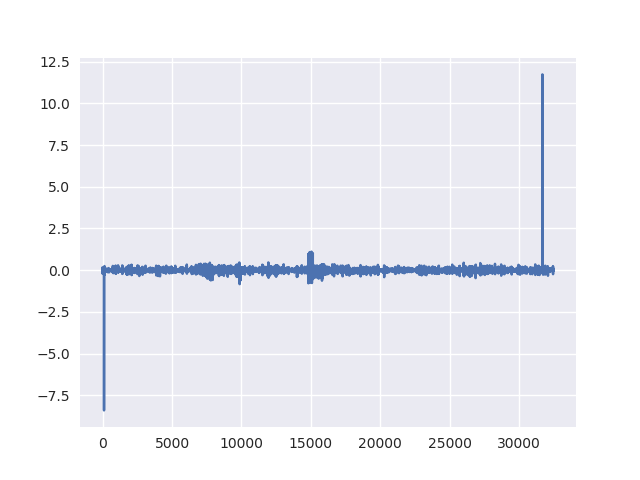

106 31665
/media/gu4n1n3/Data2/2_mice/20180221/Experiment_1/combined_interp_dff0_bandpass0.01-3.0Hz_.raw
Final Shapes
(10084, 512, 256)
(31555, 180, 320)


In [258]:
IMAGING_FRAMERATE = 1/(34704.0/1e6)
behaviour_frames = get_raw_behaviour_frames(interpolated_file, 180, 320)
combined_frames = get_processed_frames(combined_file, 512, 256)

behaviour_timestamps = open_raw_timestamps(timestamps_file)

#start, stop = get_dark_frames(behaviour_frames, 85)
start, stop = get_dark_frames_gradient_method(behaviour_frames, show_plot=True)
#start = 63
#stop = 31620
print(start, stop)
#start =  121#57 exp1_0921 #61 exp3_0921
#stop = 31678 #15384 #15391 exp1_0921 exp3_0921
behaviour_frames = behaviour_frames[start+3:stop-1, :, :]
print(combined_file)
print("Final Shapes")
print(np.shape(combined_frames))
print(np.shape(behaviour_frames))

In [257]:
#UPSCALE IMAGING VIDEO
upscale_combined_frames = np.zeros((combined_frames.shape[0]*3, 
                                    combined_frames.shape[1], 
                                    combined_frames.shape[2]),
                                  dtype = np.float32)
for i in range(len(upscale_combined_frames)):
    for j in range(3):
        upscale_combined_frames[i] = combined_frames[i//3]

combined_frames = upscale_combined_frames

In [259]:
imaging_period = 34704.0
behaviour_period = 11090.9
#behaviour_period = 16636.4
img_total_time = imaging_period*combined_frames.shape[0]
beh_total_time = behaviour_period*behaviour_frames.shape[0]

print("Imaging total time: ", img_total_time, combined_frames.shape)
print("Behaviour total time: ", beh_total_time, behaviour_frames.shape)
print(np.abs(beh_total_time-img_total_time))



    

Imaging total time:  349955136.0 (10084, 512, 256)
Behaviour total time:  349973349.5 (31555, 180, 320)
18213.5


In [38]:
#UPSCALE VERSION:
imaging_period = 34704.0/3
behaviour_period = 11090.9
#behaviour_period = 16636.4
img_total_time = imaging_period*combined_frames.shape[0]
beh_total_time = behaviour_period*behaviour_frames.shape[0]

print("Imaging total time: ", img_total_time, combined_frames.shape)
print("Behaviour total time: ", beh_total_time, behaviour_frames.shape)
print((beh_total_time-img_total_time))



Imaging total time:  349955136.0 (30252, 256, 512)
Behaviour total time:  349984440.4 (31556, 180, 320)
29304.399999976158


In [260]:
indeces = []
b = 0
tmp_img_time = img_total_time
tmp_beh_time = beh_total_time
while True:
    if tmp_img_time > tmp_beh_time:
        if b < behaviour_frames.shape[0]:
            indeces.append(b)
        tmp_img_time-=imaging_period
        if tmp_img_time < 0:
            break
        
    tmp_beh_time-= behaviour_period
    b+=1


In [261]:

img_total_time = imaging_period*combined_frames.shape[0]
beh_total_time = (np.sum(np.diff(indeces)*behaviour_period))
print("Imaging total time: ", img_total_time, combined_frames.shape)
print("Behaviour total time: ", beh_total_time, behaviour_frames.shape)
print("Difference: ", beh_total_time-img_total_time)
assert (np.abs(beh_total_time-img_total_time)) < behaviour_period*3


Imaging total time:  349955136.0 (10084, 512, 256)
Behaviour total time:  349917895.0 (31555, 180, 320)
Difference:  -37240.9999999


AssertionError: 

In [262]:
subset_video_file = video_file.split('.')[0]+"_subset_interpolated.raw"
print(subset_video_file)

/media/gu4n1n3/Data2/2_mice/20180221/Experiment_1/Behaviour/M802L_M802R_February-21_1312_experiment-1_wt_cage-mates_mouse_rail_M002Gl_subset_interpolated.raw


In [ ]:
combined_frames.astype(np.float32).tofile(directory+experiment+"combined_upscaled.raw")

In [263]:
assert len(indeces) == combined_frames.shape[0]
subset_behaviour_frames = behaviour_frames[indeces, :, :]
subset_behaviour_frames.tofile(subset_video_file)
print(subset_behaviour_frames.shape)

(10084, 180, 320)


# Load Mean Frames of Stimulation and Fixed Stim Times

In [222]:
stim_frames = np.load(fixed_stim_frames_file)
mean_stim_frames = get_raw_behaviour_frames(mean_stim_frames_file, 256, 256, np.float64)
#mask = np.load(mask_file_stim)



(200, 256, 256)


In [223]:
stim_behaviour_frames = np.zeros((stim_frames.shape[0], 200, 180, 320))
for i, stim_frame in enumerate(stim_frames):
    stim_behaviour_frames[i] = subset_behaviour_frames[stim_frame-100:stim_frame+100]

In [224]:
mean_stim_behaviour_frames = np.mean(stim_behaviour_frames, axis=0)

<IPython.core.display.Javascript object>


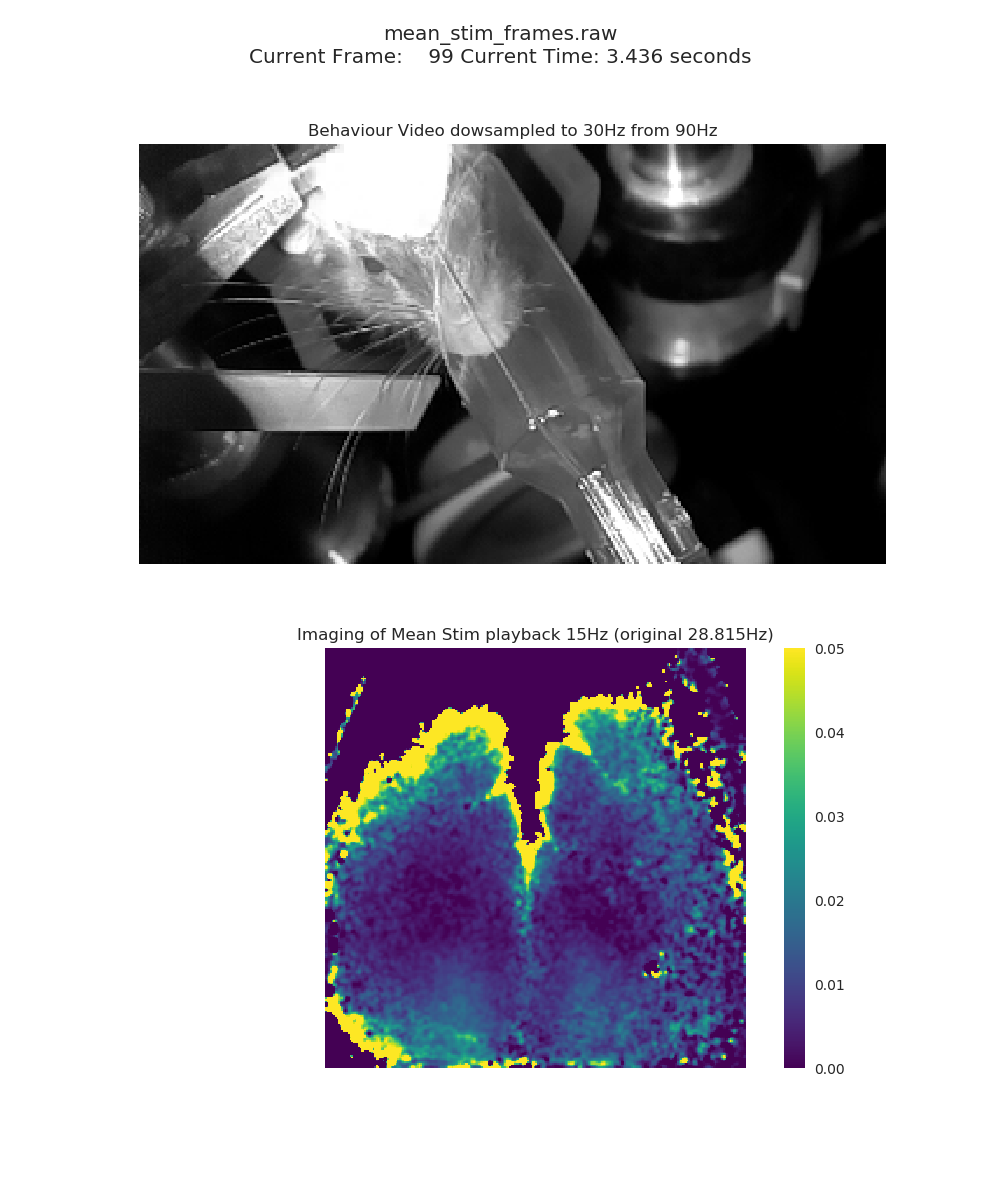

Writing frames...
Done!


In [225]:
# Write the mean imaging and mean behaviour frames to a video.
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=directory+experiment, artist='Fed',
                comment='15Hz_playback')
writer = FFMpegWriter(fps=15, metadata=metadata)
fig = plt.figure(figsize=(10, 12))
#sns.set_style('white')
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title("Behaviour Video dowsampled to 30Hz from 90Hz")
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
beh_image = ax1.imshow(mean_stim_behaviour_frames[0], clim=(0, 255), cmap='gray')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title("Imaging of Mean Stim playback 15Hz (original 28.815Hz)")
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
im_plot = ax2.imshow(mean_stim_frames[0], clim=(0, 0.05), cmap='viridis')
cbar = fig.colorbar(im_plot)


print("Writing frames...")
with writer.saving(fig, directory+experiment+video_file.split("/")[-1]+"mean_whisker_stim_video.mp4", 100):
    for i in range(mean_stim_frames.shape[0]):
        # Set title
        current_time = np.round(float(i-100)/IMAGING_FRAMERATE, 3)
        plt.suptitle(mean_stim_frames_file.split("/")[-1]+"\n"+"Current Frame: "+"{:5d}".format(i-100)+" Current Time: "+"{:4.3f}".format(current_time)+" seconds")
        
        beh_image.set_data(stim_behaviour_frames[10, i])
        frame = mean_stim_frames[i]
        frame[np.where(frame==np.inf)] = -1
        frame = gaussian_filter(frame, 1)
        im_plot.set_data(frame)


        writer.grab_frame()
print("Done!")

<IPython.core.display.Javascript object>


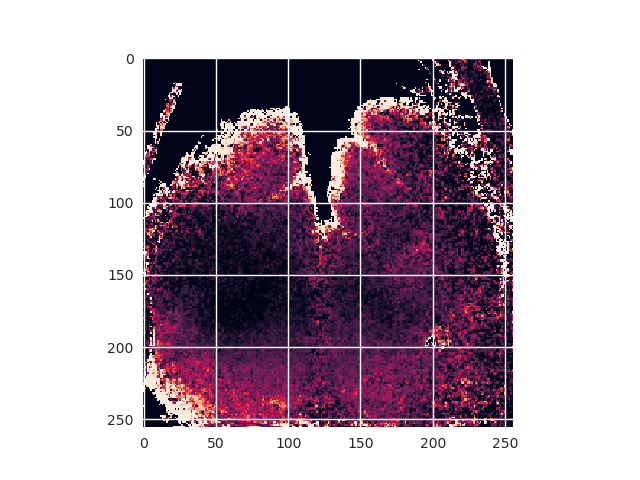

inf


In [205]:
plt.figure()
plt.imshow(mean_stim_frames[106], vmin=0, vmax=0.05)
print(gaussian_filter(mean_stim_frames[106], 1)[25, 15])

In [71]:
#maps_oi = [0, 1]
#maps_oi = [0, 2]
maps_oi = [3, 4]
#maps_oi = [1, 2, 3, 5]
maps=[]
for root, dirs, files in os.walk(directory+experiment+"Maps/"):
    if "Maps" in root:
        for file in files:
            if ".npy" in file:
                print(file)
                for moi in maps_oi:
                    if "_"+str(moi)+"." in file:
                        print(moi)
                        mp = np.load(directory+experiment+"Maps/"+file)
                        # Make mouse on right zero.
                        #mp[:, 256:] = 0
                        maps.append(mp)
                        print(directory+experiment+"Maps/"+file)

maps=np.asarray(maps)                
maps[np.where(np.isnan(maps))] = 0


map_0.npy
map_4.npy
4
/media/gu4n1n3/Data2/2_mice/20180208/Experiment_2/Maps/map_4.npy
map_2.npy
map_1.npy
map_3.npy
3
/media/gu4n1n3/Data2/2_mice/20180208/Experiment_2/Maps/map_3.npy


In [79]:
combined_frames[np.where(np.isnan(combined_frames))] = 0
print(np.mean(combined_frames))

0.0145909


In [73]:
signal_threshold = 0.05 # 5% dF/F0 signal before it counts as a transient.
pre_inter_number_transients  = [[], [], []]
inter_number_transients      = [[], [], []]
post_inter_number_transients = [[], [], []]

In [133]:
frame_interaction_start = 3135
frame_interaction_end = 7430

length_initial_separation = frame_interaction_start/IMAGING_FRAMERATE
length_interaction = (frame_interaction_end-frame_interaction_start)/IMAGING_FRAMERATE
length_second_separation = (np.shape(combined_frames)[0]-frame_interaction_end)/IMAGING_FRAMERATE

print(length_initial_separation)
print(length_interaction)
print(length_second_separation)

# Type 0 = wt/wt
# Type 1 = shank3/shank3/
# Type 2 = shank3/wt
current_experiment_type = 2
index = 1



108.79704
149.05367999999999
92.104416


In [118]:
pre_inter_number_transients[current_experiment_type].append(0)
inter_number_transients[current_experiment_type].append(0)
post_inter_number_transients[current_experiment_type].append(0)


In [105]:
pre_inter_number_transients[current_experiment_type][index] = 0
inter_number_transients[current_experiment_type][index] = 0
post_inter_number_transients[current_experiment_type][index] = 0

<IPython.core.display.Javascript object>


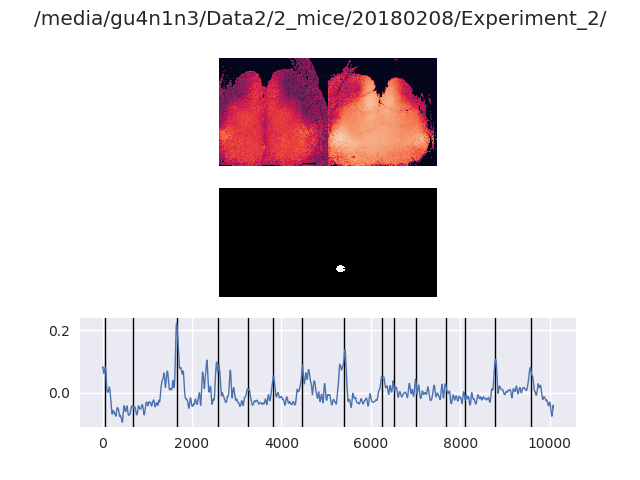

(256, 512)
(256, 512)
(10083, 256, 512)


<IPython.core.display.Javascript object>


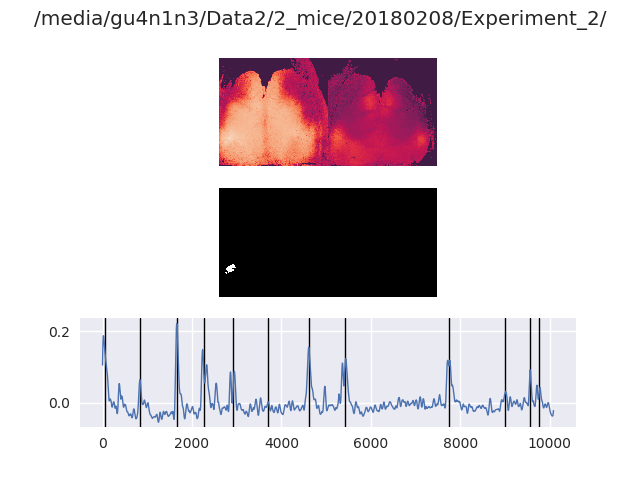

(256, 512)
(256, 512)
(10083, 256, 512)


In [93]:
import cv2
signals_of_interest = []
rois_trace_indeces = []
thresholds = [(185, 255), (186, 255), (183, 200), (185, 200)]
for m, mp in enumerate(maps):
    img = cv2.GaussianBlur(mp,(5, 5),0)
    img+=1
    img*=100
    img = img.astype(np.uint8)
    ret, thresh = cv2.threshold(img, thresholds[m][0], thresholds[m][1], 0)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(mp)
    trace_mask = np.zeros_like(mp)
    cv2.drawContours(mask, contours, -1, (1), -1)
    cv2.drawContours(trace_mask, contours, -1, (1), 1)
    list_of_points_indices=np.where(mask>0)
    list_of_points_indices_trace=np.where(trace_mask>0)
    rois_trace_indeces.append(list_of_points_indices_trace)
    #print(list_of_points_indices)
    fig = plt.figure()
    fig.suptitle(directory+experiment)
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    a = np.copy(mp)
    a[list_of_points_indices_trace] = 255
    ax1.imshow(mp)
    
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax2.imshow(mask, 'gray')
    
    
    ax3 = fig.add_subplot(3, 1, 3)
    signals_of_interest.append(np.mean(combined_frames[:,list_of_points_indices[0], list_of_points_indices[1]], axis=1))
    sizes = np.arange(60, 200)
    #peakind = find_peaks_cwt(signals_of_interest[m], sizes)
    sigma = 2
    signal = savgol_filter(signals_of_interest[m], 151, 6)
    peakind = find_peaks_cwt(signal, sizes, min_snr=1)
    #gauss = gaussian(21, std=33)
    #signal = np.convolve(signals_of_interest[m], gauss)
    #threshold = np.mean(signal)+sigma*np.std(signal)
    #ax3.axhline(threshold, linewidth=1.0, color='r')
    for ind in peakind:
        if signals_of_interest[m][ind] > signal_threshold and False:
            if ind < frame_interaction_start:
                pre_inter_number_transients[current_experiment_type][index] += 1 / length_initial_separation
            elif ind >= frame_interaction_start and ind <= frame_interaction_end:
                inter_number_transients[current_experiment_type][index] += 1 / length_interaction
            elif ind > frame_interaction_end:
                post_inter_number_transients[current_experiment_type][index] += 1 / length_second_separation

        if True:
            ax3.axvline(ind, linewidth=1.0, color='k')
            
    
    ax3.plot(signal, linewidth=1)
    print(np.shape(img))
    print(np.shape(mask))
    print(np.shape(combined_frames))
    plt.savefig(directory+experiment+"activity_%s.png"%(str(maps_oi[m])))


In [157]:
print(pre_inter_number_transients)
print(inter_number_transients)
print(post_inter_number_transients)
pre_inter_number_transients = [[0.018895162082700347, 0.04723790520675086], [0.09220839096357768], [0.046930166410615676, 0.009191426531457107]]
inter_number_transients = [[0.03583970419915178, 0.05017558587881249], [0.10026441906969961], [0.08186114254578986, 0.06708992357652625]]
post_inter_number_transients = [[0.0382417016272303, 0.04781799232678066], [0.051849072741552905], [0.018341898266147693, 0]]

pre_x = []
during_x = []
post_x = []

for i in range(len(pre_inter_number_transients)):
    pre_x.append([])
    during_x.append([])
    post_x.append([])
    for j in range(len(pre_inter_number_transients[i])):
        pre_x[i].append(i)
        during_x[i].append(i)
        post_x[i].append(i)
        
print(pre_x)
print(during_x)
print(post_x)

[[0.018895162082700347, 0.04723790520675086], [0.09220839096357768], [0.046930166410615676, 0.009191426531457107]]
[[0.03583970419915178, 0.05017558587881249], [0.10026441906969961], [0.08186114254578986, 0.06708992357652625]]
[[0.0382417016272303, 0.04781799232678066], [0.051849072741552905], [0.018341898266147693, 0]]
[[0, 0], [1], [2, 2]]
[[0, 0], [1], [2, 2]]
[[0, 0], [1], [2, 2]]


<IPython.core.display.Javascript object>


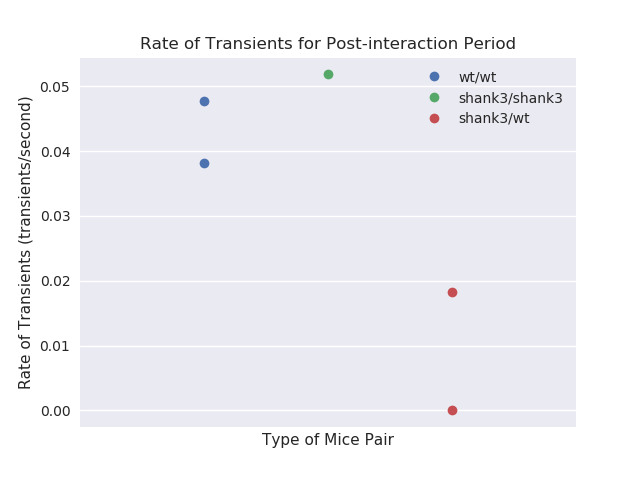

[[0.018895162082700347, 0.04723790520675086], [0.09220839096357768], [0.046930166410615676, 0.009191426531457107]]
[[0.03583970419915178, 0.05017558587881249], [0.10026441906969961], [0.08186114254578986, 0.06708992357652625]]
[[0.0382417016272303, 0.04781799232678066], [0.051849072741552905], [0.018341898266147693, 0]]


In [173]:
legends = ["wt/wt", "shank3/shank3", "shank3/wt"]
plt.figure()
plt.title("Rate of Transients for Pinteraction Period")
plt.xticks([])
plt.xlim([-1, 3])
plt.xlabel("Type of Mice Pair")
plt.ylabel("Rate of Transients (transients/second)")
counter = 0
for x, y in zip(pre_x, post_inter_number_transients):
    
    plt.plot(x, y, 'o', label=legends[counter])
    counter+=1
plt.legend()
plt.show()
    
print(pre_inter_number_transients)
print(inter_number_transients)
print(post_inter_number_transients)

/home/gu4n1n3/Applications/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "/home/gu4n1n3/Applications/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/gu4n1n3/Applications/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/gu4n1n3/Applications/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/gu4n1n3/Applications/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/home/gu4n1n3/Applications/anaconda3/lib/python3.5/site-packa

<IPython.core.display.Javascript object>


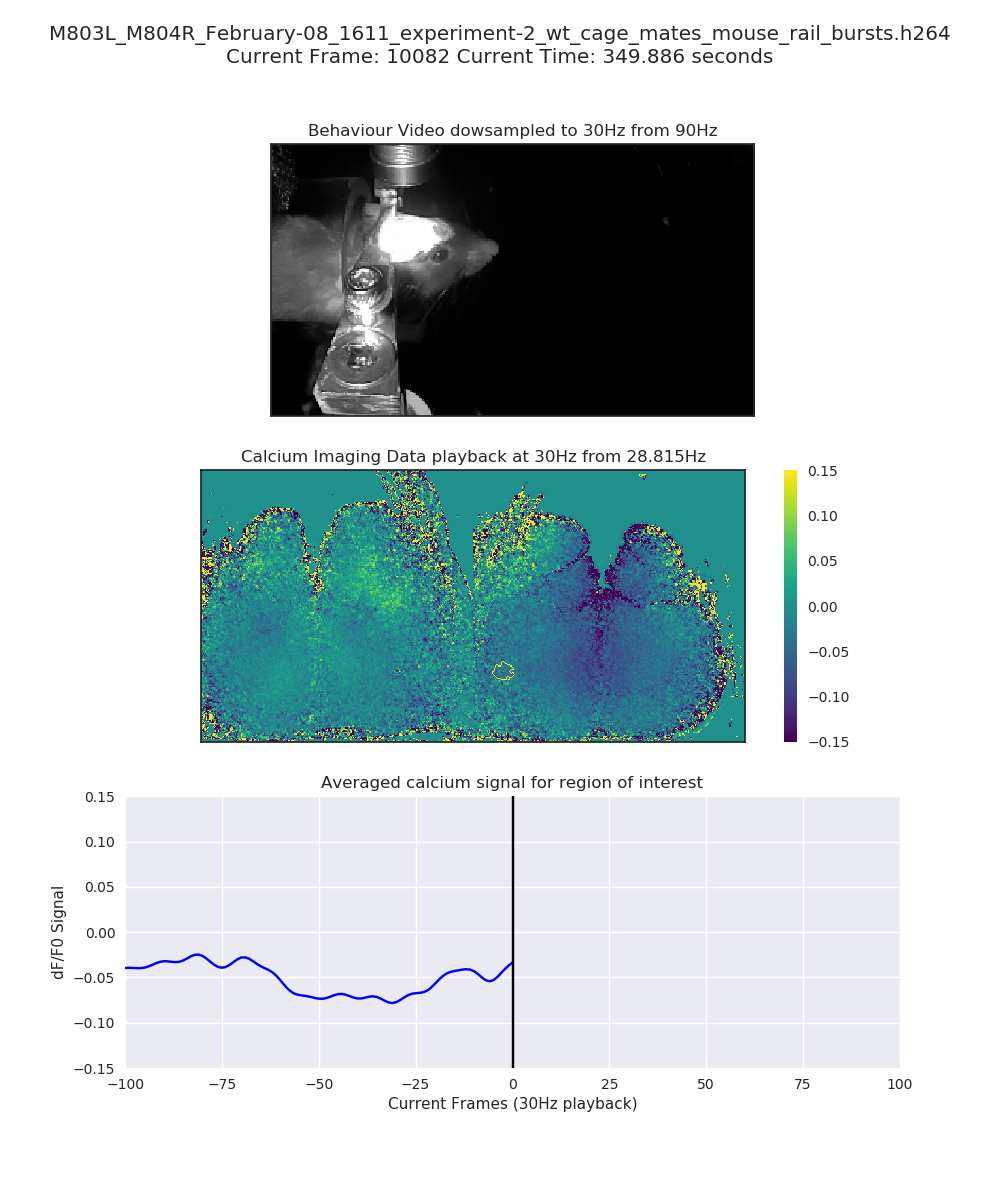

Writing frames...
Done!


<IPython.core.display.Javascript object>


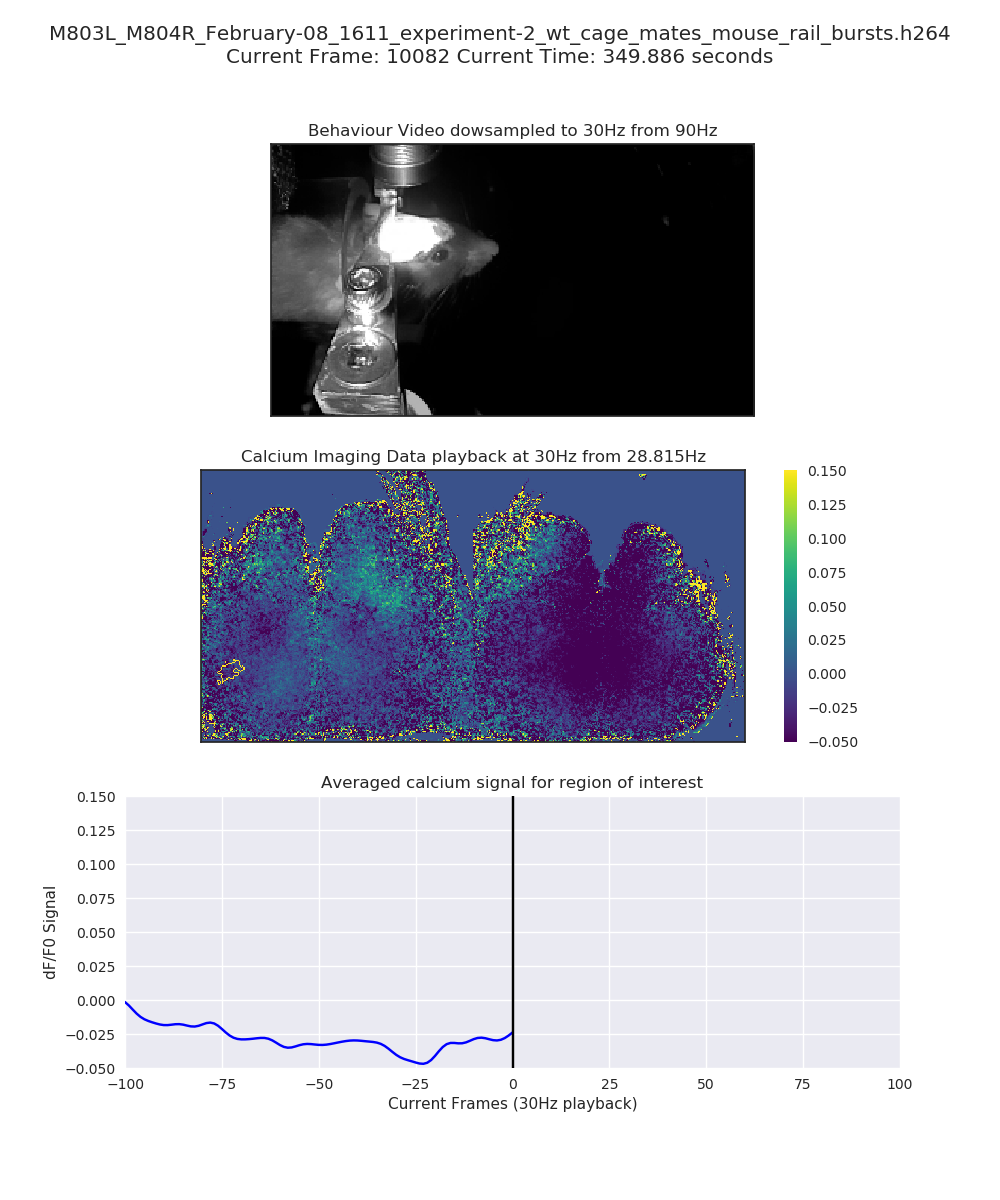

Writing frames...
Done!


In [80]:
# Make videos of the signals.
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
for s, signal in enumerate(signals_of_interest):
    FFMpegWriter = manimation.writers['ffmpeg']
    metadata = dict(title=directory+experiment, artist='Fed',
                    comment='30Hz_playback')
    writer = FFMpegWriter(fps=30, metadata=metadata)
    fig = plt.figure(figsize=(10, 12))
    sns.set_style('white')
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.set_title("Behaviour Video dowsampled to 30Hz from 90Hz")
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    beh_image = ax1.imshow(subset_behaviour_frames[0], clim=(0, 255), cmap='gray')
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.set_title("Calcium Imaging Data playback at 30Hz from 28.815Hz")
    ax2.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    im_plot = ax2.imshow(combined_frames[0], clim=(-.05, 0.15), cmap='viridis')
    cbar = fig.colorbar(im_plot)
    sns.set_style('darkgrid')
    ax3 = fig.add_subplot(3, 1, 3)
    l, = ax3.plot([], [], 'b-')
    ax3.set_title("Averaged calcium signal for region of interest")
    ax3.set_ylabel("dF/F0 Signal")
    ax3.set_xlabel("Current Frames (30Hz playback)")
    
    #img = plt.imshow(combined_frames[0], cmap='viridis')
    ylim_1 = -.05
    ylim_2 = .15
    current_ylim_1 = ylim_1
    current_ylim_2 = ylim_2
    plt.xlim(-100, 100)
    plt.ylim(ylim_1, ylim_2)
    plt.axvline(0, color='k')
    print("Writing frames...")
    with writer.saving(fig, directory+experiment+video_file.split("/")[-1]+"combined_video_%s.mp4"%(str(s)), 100):
        for i in range(len(signal)):
            # Set title
            current_time = np.round(float(i)/IMAGING_FRAMERATE, 3)
            plt.suptitle(video_file.split("/")[-1]+"\n"+"Current Frame: "+"{:5d}".format(i)+" Current Time: "+"{:4.3f}".format(current_time)+" seconds")
            if i < 100:
                l.set_data(np.arange(-i, 100), signal[0:i+100])
                current_min = np.min(signal[0:i+100])
                current_max = np.max(signal[0:i+100])
            elif i > len(signal)-100:
                l.set_data(np.arange(-100, len(signal)-i), signal[i-100:])
                current_min = np.min(signal[i-100:])
                current_max = np.max(signal[i-100:])
            else:
                l.set_data(np.arange(-100,100), signal[i-100:i+100])
                current_min = np.min(signal[i-100:i+100])
                current_max = np.max(signal[i-100:i+100])
                
            if current_min < ylim_1:
                current_ylim_1 = current_min
                current_ylim_1 = float(int(round((current_min*100-5)/5.0)*5.0))/100
                
            elif current_min > ylim_1:
                current_ylim_1 = ylim_1
                
            if current_max > ylim_2:
                current_ylim_2 = current_max+0.05
                # Following operation makes sure that if max is 0.12 limit becomes 0.15
                current_ylim_2 = float(int(round((current_max*100+5)/5.0)*5.0))/100
            elif current_max < ylim_2:
                current_ylim_2 = ylim_2
                
            plt.ylim(current_ylim_1, current_ylim_2)
            beh_image.set_data(subset_behaviour_frames[i])
            cp = np.copy(combined_frames[i])
            cp[rois_trace_indeces[s]] = 1
            im_plot.set_data(cp)
            im_plot.set_clim(current_ylim_1, current_ylim_2)
            
            
            writer.grab_frame()
    print("Done!")

In [91]:
diffs_xx_hl = []

<IPython.core.display.Javascript object>


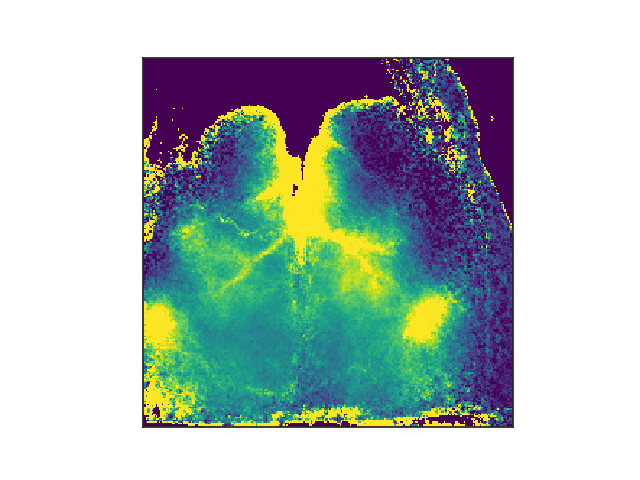

([], <a list of 0 Text xticklabel objects>)

In [89]:
plt.figure()
sns.set_style('white')
plt.imshow(combined_frames[1649, 0:256, 0:256], vmin=0, vmax=0.25, cmap='viridis')
plt.yticks([])
plt.xticks([])

0 1


<IPython.core.display.Javascript object>


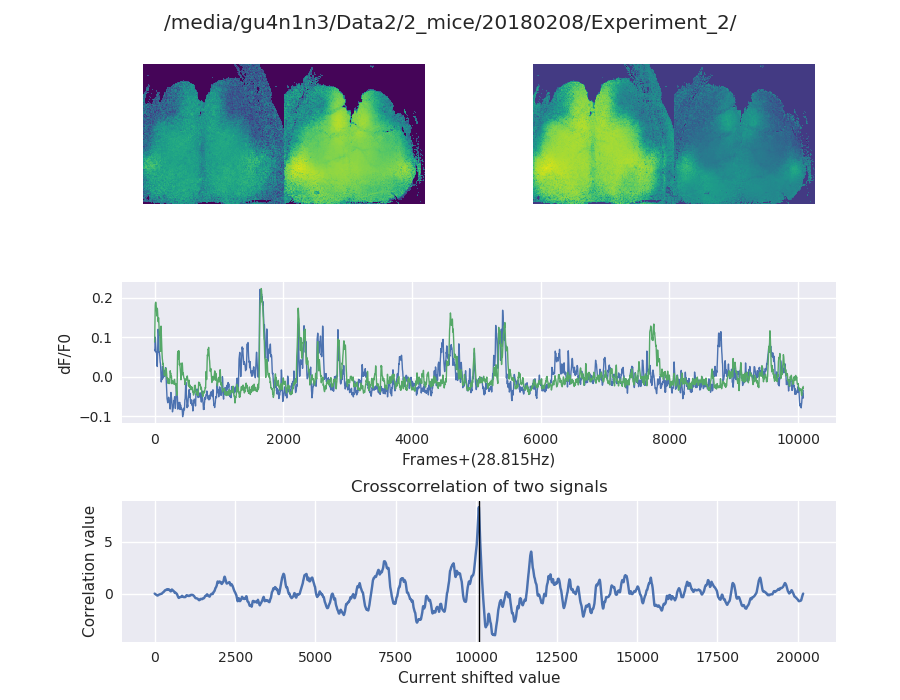

[-3]


In [92]:
#Cross correlations
import seaborn as sns
sns.set()
for s, signal in enumerate(signals_of_interest):
    for r in range(s+1, len(signals_of_interest)):
        print(s, r)
        plt.figure(figsize=(9, 7))
        plt.suptitle(directory+experiment)
        sns.set_style('white')
        plt.subplot(3,2,1)
        plt.axis('off')
        plt.imshow(maps[s], cmap='viridis')
        plt.subplot(3,2,2)
        plt.axis('off')
        plt.imshow(maps[r], cmap='viridis')
        
        
        sns.set_style('darkgrid')
        plt.subplot(3,1,2)
        plt.plot(signal, linewidth=1.0)
        plt.plot(signals_of_interest[r], linewidth=1.0)
        plt.xlabel('Frames+(28.815Hz)')
        plt.ylabel('dF/F0')
        
        sig1 = signals_of_interest[s]#[:-2]
        sig2 = signals_of_interest[r]#[2:]
        coeffs = np.correlate(sig1, sig2, "full")
        diffs_xx_hl.append(np.argmax(coeffs)-len(sig1))
        print(diffs_xx_hl)
        plt.tight_layout(pad=3.5, w_pad=1.5, h_pad=2.0)
        plt.subplot(3,1,3)
        
        plt.plot(coeffs)
        plt.axvline(len(sig1), linewidth=1, color='k')
        plt.title("\n\nCrosscorrelation of two signals")
        plt.ylabel("Correlation value")
        plt.xlabel("Current shifted value")
        
plt.savefig(directory+experiment+"roi_CROSScorrelation.png")
plt.show()

In [30]:

print(np.mean(diffs_xx_hl))
print(np.std(diffs_xx_hl))

6438.0
0.0


In [31]:
UPSCALED_FS = IMAGING_FRAMERATE

title = combined_file.split('/')[-1]
title1 = "\ncorr coeff: " + str(pearsonr(signals_of_interest[0], signals_of_interest[1])[0])
title2 = "\ncorr coeff: " + str(pearsonr(signals_of_interest[2], signals_of_interest[3])[0])
plt.figure()
colors=['k', 'r', 'g', 'b']
for s,signal in enumerate(signals_of_interest):
    if s<=1:
        plt.subplot(2,1,1)
        plt.title(title1)
        plt.plot(signal, colors[s],linewidth=1)
        plt.xlabel('Frames(28.815Hz)')
        plt.ylabel('dF/F0')
    
    if s>1:
#         f, psd = welch(signal, UPSCALED_FS, nperseg=8192 )
#         plt.semilogy(f, psd)
#         plt.xlabel('Frequency (Hz)')
#         plt.ylabel('PSD [V**2/Hz]')
        plt.subplot(2,1,2)
        plt.title(title2)
        plt.plot(signal, colors[s],linewidth=1)
        plt.xlabel('Frames(28.815Hz)')
        plt.ylabel('dF/F0')
        
print(np.corrcoef(signals_of_interest))
    
plt.show()

IndexError: list index out of range

0 1


<IPython.core.display.Javascript object>


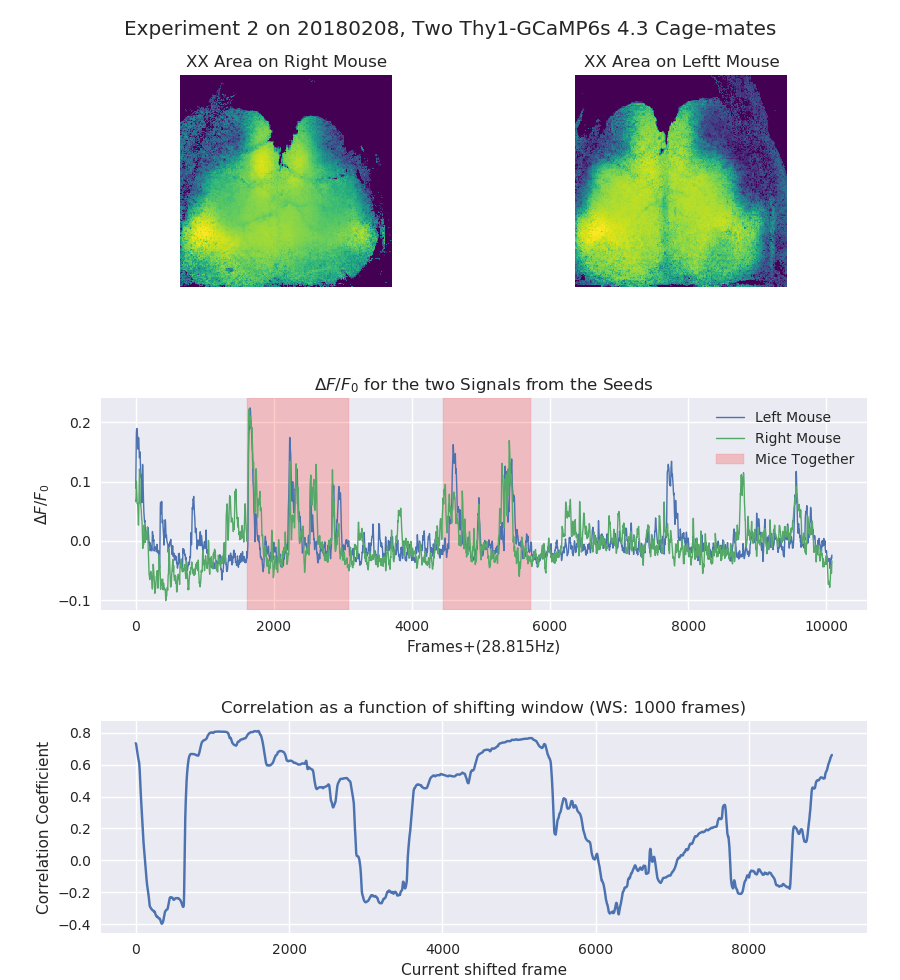

10083


In [114]:
import seaborn as sns
sns.set()

window_size = 1000

start_interactions = [1617, 4451]
end_interactions = [3090, 5719]

for s, signal in enumerate(signals_of_interest):
    for r in range(s+1, len(signals_of_interest)):
        print(s, r)
        plt.figure(figsize=(9, 7))
        #plt.suptitle(directory+experiment)
        plt.suptitle("Experiment 2 on 20180208, Two Thy1-GCaMP6s 4.3 Cage-mates")
        sns.set_style('white')
        plt.subplot(3,2,1)
        plt.axis('off')
        plt.title("XX Area on Right Mouse")
        plt.imshow(maps[s,  :, 256:], cmap='viridis', vmin=0.1, vmax=0.9)
        plt.subplot(3,2,2)
        plt.axis('off')
        plt.imshow(maps[r,  :, 0:256], cmap='viridis', vmin=0.1, vmax=0.9)
        plt.title("XX Area on Leftt Mouse")
        plt.axis('off')
        sns.set_style('darkgrid')
        plt.subplot(3,1,2)
        plt.title(r"$\Delta F/F_0$ for the two Signals from the Seeds")
        plt.plot(signals_of_interest[r], linewidth=1.0, label="Left Mouse")
        plt.plot(signals_of_interest[s], linewidth=1.0, label="Right Mouse")
        
        for start, end in zip(start_interactions, end_interactions):
            plt.axvspan(start, end, alpha=0.2, color='r', label="Mice Together")
        
        #for end in end_interactions:
        #    plt.axvline(end, color='m', linewidth=1.0, label="Separation")
        plt.xlabel('Frames+(28.815Hz)')
        plt.ylabel(r'$\Delta F/F_0$')
        plt.legend()
        
        
        correlations = []
        plt.tight_layout(pad=2, w_pad=1.5, h_pad=2.0)
        plt.subplot(3,1,3)
        print(len(signal))
        for i in range(len(signal)-window_size):
            #print(np.mean(signal[i:i+window_size]))
            #print(np.mean(signals_of_interest[r][:i:i+window_size]))
            correlations.append(pearsonr(signal[i:i+window_size], signals_of_interest[r][i:i+window_size])[0])
        plt.plot(correlations)
        plt.title("\n\nCorrelation as a function of shifting window (WS: %s frames)" %(str(window_size)))
        plt.ylabel("Correlation Coefficient")
        plt.xlabel("Current shifted frame")
        #plt.ylim([-0.2,1])
plt.savefig(directory+experiment+"roi_correlation.png")
plt.show()

/home/gu4n1n3/Applications/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


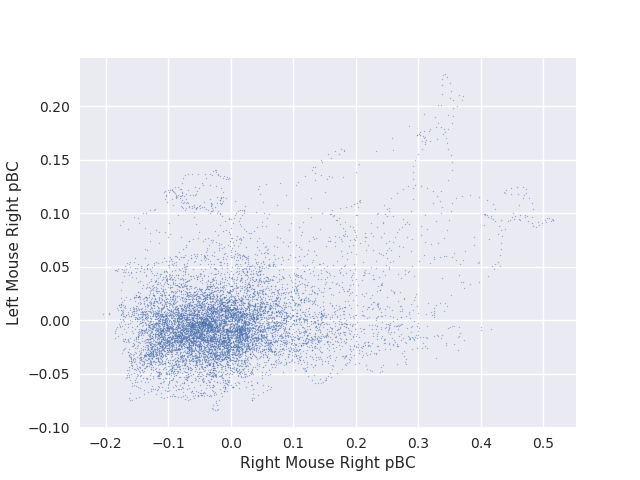

In [112]:
# Plotting points with each other.

plt.figure()
plt.plot(signals_of_interest[0], signals_of_interest[1], '.', markersize=2, alpha=0.5)
plt.ylabel("Left Mouse Right pBC")
plt.xlabel("Right Mouse Right pBC")
plt.show()

In [ ]:
#f = plt.figure(figsize=(8, 12))
correlations = np.zeros((len(maps), combined_frames.shape[0]))
print("woof", correlations.shape)
for f, frame in enumerate(combined_frames):
    frame = frame[:, 256:]
    frame[np.where(np.isnan(frame))] = 0
    frame = np.reshape(frame, (frame.shape[0]*frame.shape[1]))
    for m, mp in enumerate(maps):
        mp = mp[:, 256:]
        mp[np.where(np.isnan(mp))] = 0
        mp = np.reshape(mp, (mp.shape[0]*mp.shape[1]))
        #correlations[m, f] = correlate2d(frame,mp, 'valid')[0][0]
        
        correlations[m, f] = pearsonr(frame, mp)[0]
   

In [ ]:
              
f = plt.figure(figsize=(8, 12))

counter = 0
for i, map in enumerate(maps):
    counter+=1
    ax = f.add_subplot(len(maps)*2, 1, counter)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(map[:, 256:])
    counter+=1
    ax = f.add_subplot(len(maps)*2, 1, counter)
    ax.plot(correlations[i, :])
    print(correlations[i])
plt.show()

In [ ]:
# Remove metal posts
foi_behaviour_frames = subset_behaviour_frames[:, :subset_behaviour_frames.shape[1], :]
print(np.shape(foi_behaviour_frames))

In [ ]:
# FED method, all videos concatanated temporally, no overlapping frames.
threshold = 0.1
time_window = 90
fois = np.where(correlations[0]>=threshold)
fois_diffs = np.diff(fois)
filtered_fois = []
filtered_fois.append(fois[0][0])

for i, foi_diff in enumerate(fois_diffs[0]):
    if foi_diff > 1:
        filtered_fois.append(fois[0][i])
               
true_fois = []
for foi in filtered_fois:
    if true_fois == []:
        start = foi-time_window
    elif (foi-time_window) > true_fois[-1]: 
        start = foi-time_window
    else:
        start = true_fois[-1]+1
    for lmao in range(start, foi+time_window):
        true_fois.append(lmao)
        


In [ ]:
# JEFF method, all videos combined spatially, same length in time.
threshold = 0.02
time_window = 240
fois = np.where(correlations[0]>=threshold)
fois_diffs = np.diff(fois)

#print(correlations[0][np.where(correlations[0]>= threshold)])
#print(fois)
event_indeces = [] # List of events,each event is a list of indeces, must find max correlation.
event_count = 0
time_point_count = 0
event_indeces.append([])
for i, foi_diff in enumerate(fois_diffs[0]):
    if foi_diff+time_point_count <= 30:
        event_indeces[event_count].append(fois[0][i+1])
        time_point_count+=foi_diff
    if foi_diff+time_point_count > 260:
        event_indeces.append([])
        event_count+=1
        time_point_count = 0
        
# In event indeces now we have our list of events and all the indeces.
# Now we must maximize the correlation coefficient.
filtered_fois = []
for event in event_indeces:
    #plt.figure()
    #plt.plot(correlations[0][event])
    #print(event)
    filtered_fois.append(event[0]+np.argmax(correlations[0][event]))
        
plt.show()
    
print("LOL", filtered_fois)
true_fois = []
for foi in filtered_fois:
    if foi+time_window >= foi_behaviour_frames.shape[0]:
        break
    a = [x for x in range(foi-time_window, foi+time_window)]
    true_fois.append(a)

print(np.shape(true_fois) )
#print(true_fois)
#Combine them.
# print(np.shape(behaviour_frames))
# motif_behaviour_frames = np.zeros((len(true_fois[0]), foi_behaviour_frames.shape[1]*len(true_fois), foi_behaviour_frames.shape[2]))
# motif_imaging_frames = np.zeros((len(true_fois[0]), combined_frames.shape[1]*len(true_fois), combined_frames.shape[2]))
# print(np.shape(motif_behaviour_frames))
# print(np.shape(motif_imaging_frames))
# for i, foi in enumerate(true_fois):
#     motif_behaviour_frames[:, i*foi_behaviour_frames.shape[1]:(i+1)*foi_behaviour_frames.shape[1]] = foi_behaviour_frames[foi]
#     motif_imaging_frames[:, i*combined_frames.shape[1]:(i+1)*combined_frames.shape[1]] = combined_frames[foi]


print(np.shape(behaviour_frames))
motif_behaviour_frames = np.zeros((len(true_fois[0]), len(true_fois), foi_behaviour_frames.shape[1], foi_behaviour_frames.shape[2]))
motif_imaging_frames = np.zeros((len(true_fois[0]), len(true_fois), combined_frames.shape[1], combined_frames.shape[2]))
print(np.shape(motif_behaviour_frames))
print(np.shape(motif_imaging_frames))
for i, foi in enumerate(true_fois):
    motif_behaviour_frames[:, i, :, :] = foi_behaviour_frames[foi]
    motif_imaging_frames[:, i, :, :] = combined_frames[foi]


In [ ]:
motif_behaviour_frames = np.mean(motif_behaviour_frames, axis=1)
motif_imaging_frames = np.mean(motif_imaging_frames, axis= 1)
print(motif_behaviour_frames.shape, motif_imaging_frames.shape)
motif_behaviour_frames.astype(np.float32).tofile(directory+experiment+"special_behaviour_BC_mean_strong_right.raw")
motif_imaging_frames.astype(np.float32).tofile(directory+experiment+"special_imaging_BC_mean_strong_right.raw")

In [ ]:
ob_behaviour_frames = behaviour_frames[np.where(true_fois), ob_behaviour_frames.shape[1]/2]
ob_imaging_frames = combined_frames[np.where(true_fois)]

ob_behaviour_frames.astype(np.float32).tofile(directory+experiment+"ob_plus_behaviour_frames_right.raw")
ob_imaging_frames.astype(np.float32).tofile(directory+experiment+"ob_plus_imaging_frames_right.raw")